## Imports

In [1]:
import csv
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
from matplotlib.pyplot import cm

import numpy as np
import trompy as tp
from datetime import datetime
import pandas as pd
import pickle 

%matplotlib inline


from scipy import stats

In [2]:
def extract_event_fn(filename): 
    '''
    function to extract framenumber of events (licks and pump_on) in framenumber
    
    args
    filename - string 
    
    returns 
    licks_fn - lits of integers
        framenumber of licks
    pump_on_fn - list of integers 
        framenumber when pump turns on
    
    '''
    df= pd.read_csv(filename)
    
    #Extracts pump on framenumber
    pump_fn = list(df[df['Item1'] == 'pump_on']['Item2.Item2'])
    
    
    #Extracts licks framenumber
    licks_fn = list (df[df['Item1']== 'Lick']['Item2.Item2'])

      
    return pump_fn, licks_fn
        


In [3]:
def get_hit_miss_trial (pump_fn, licks_fn): 
    '''
    function to get hit and miss trials
    
    arg 
    pump_fn - list of integers
        framenumber for when the pump turns on 
    licks_fn - list of integers
        framenumber for all licks
    triallenght - int float (optional, default set to 100 frames (10sec))
    
    returns 
    hit_trial - list of int 
        pump on frame number in hit trials (lick > 0)
    miss_trial - list of int 
        pump on frame number in missed trials (lick = 0)
    
    '''
    hit_trial=[]
    miss_trial=[]
    for p in pump_fn: 
        temp=[]
        for lick in licks_fn: 
            if lick > p and lick < p + 100: 
                temp.append(lick)
            
        if len(temp)> 0:
            hit_trial.append(p)
        if len(temp) == 0: 
            miss_trial.append(p)
    return hit_trial, miss_trial

In [4]:
def get_licks_trial (pump_fn, licks_fn, triallength=100):
    '''
    function to get licks within one trial 
    licks aligned to pump on (pump_fn)
    
    arg 
    pump_fn - list of integers
        framenumber for when the pump turns on 
    licks_fn - list of integers
        framenumber for all licks
    triallenght - int float (optional, default set to 100 frames (10sec))
    
    returns 
    licks_trial - list of list of integers
        list of all licks in all trials aligned to pump on (in frames)
    licks_all_trial - list of integers
        number of licks of each trial 
    licks_hit_trial - list of integers 
        number of licks per trial for hit trials 
    latency - list of integers
        latency to first lick after pump on (in frames)
        
    
    '''

    # All licks aligned to pump on 
    licks_trial=[]
    for p in pump_fn:
        temp=[]
        for lick in licks_fn: 
            if lick > p and lick < p + 100:
                temp.append(lick - p)
        licks_trial.append(temp)
        
        
    #licks per trial (all and hit trials) aligned to pump on 
    licks_all_trial=[]
    licks_hit_trial=[]
    for trial in licks_trial: 
        licks_all_trial.append(len(trial))
        if len(trial) > 0: 
            licks_hit_trial.append(len(trial))
            
            
    #Latency to first lick after pump on
    temp_latency=[]
    for trial in licks_trial:
        if len(trial) > 0: 
            temp_latency.append(trial[:1])
    
    latency=[trial for sublist in temp_latency for trial in sublist] #List comprehension to convert list of lists to flat list     
            
        
    return licks_trial, licks_all_trial, licks_hit_trial, latency

In [5]:
def make_barscatter(data, ax=None, barlabels=['PR','PRNR','NR','NRPR'], barfacecolor = ['darkcyan','c', 'black', 'grey']):
    
    '''
    function to make barscatter
    
    arg 
    data - list of lists of floats
        The data you want to put into the plot
    barlabels - list of strings
        labels for the bars plotted (optional - defaulte : 'PR','PRNR','NR','NRPR' )
    barfacecolors - list of strings
        colors for the bars (optional- default: ['darkcyan','c', 'black', 'grey'])
    
    
    returns 
    ax - ax to put into sublot
    
    '''
    if ax == None: 
        f,ax = plt.subplots()
        
    tp.barscatter(data, 
                  paired= True,
                  barfacecolor=barfacecolor,
                  barlabels=barlabels,
                  barlabeloffset=0.04,
                  barfacecolor_option='individual',
                  fontsize = 15,
                  scattersize=110,
                  scatteralpha=0.7,
                  spaced=True,
                  linewidth=1.5,
                  ax=ax)
    
    return ax
    

## Metafile reader

In [6]:
rows,header=tp.metafilereader('C:\\Users\\mko102\\UiT Office 365\\O365-Pipette 2 - Dokumenter\\People\\Mette\\GitHub\\2P\\Metafile_VGP2.2.xls',sheetname='Behavior')
# rows_homecage,header=tp.metafilereader('C:\\Users\\mko102\\UiT Office 365\\O365-Pipette 2 - Dokumenter\\People\\Mette\\GitHub\\2P\\Metafile_VGP2.2.xls',sheetname='Homecage')
folder= 'C:\\Users\\mko102\\UiT Office 365\\O365-Pipette 2 - Dokumenter\\People\\Mette\\GitHub\\2P\\VGP2\\Bonsai\\'

File is excel file. Making csv metafile first


## Dictionary

In [7]:
all_data={}

for row in rows: 
    try:
        key=row[0]+ '_' + row[4]
    
        pump_fn, licks_fn = extract_event_fn(folder+row[1])
        hit_trial, miss_trial = get_hit_miss_trial(pump_fn, licks_fn)
        licks_trial, licks_all_trial, licks_hit_trial, latency = get_licks_trial(pump_fn, licks_fn)
        
        lick_number=[]
        for number, lick in enumerate(licks_fn): 
            lick_number.append(number)
    
        
    
        all_data[key]={}

        all_data[key]['mouse']=row[0]
        all_data[key]['diet']=row[7]
        all_data[key]['solution']=row[8]
        all_data[key]['session']=row[10]
    
#         all_data[key]['file']=row[1]
        all_data[key]['licks_fn']= licks_fn
        all_data[key]['number lick']= [number for number in range(1,(len(licks_fn)+1))]
        all_data[key]['lick number']= lick_number
        all_data[key]['pump_fn']= pump_fn
        all_data[key]['licks trial']= licks_trial
        all_data[key]['number of trials']=len(pump_fn)
        all_data[key]['total licks']=len(licks_fn)
        all_data[key]['hit trial'] = len(hit_trial)
        all_data[key]['miss trials']= len(miss_trial)
        all_data[key]['licks per trial']= np.mean(licks_all_trial)
        all_data[key]['licks hit trial']= np.mean(licks_hit_trial)
        all_data[key]['latency']= np.mean(latency)
        all_data[key]['latency all']=latency
    
    except FileNotFoundError: 
        print('Cannot find file for', key)

In [8]:

with open('..//output//behavdata.pickle', 'wb') as file:
    pickle.dump(all_data, file, protocol=pickle.HIGHEST_PROTOCOL)

with open('..//output//behavdata.pickle', 'rb') as file:
    b = pickle.load(file)

# Making groups and figures

In [9]:
mice=[]

for key in all_data.keys(): 
    d=all_data[key]
    mouseid=d['mouse']
    if mouseid not in mice: mice.append(mouseid)


for m in mice: 
    if m == 'VGP305':
        mice.remove(m)


## Total number of licks

Baseline

In [10]:
baseline_NR=[]
baseline_PR=[]

for mouse in mice: 
    temp_NR=[]
    temp_PR=[]
    
    for key in all_data.keys():
        d=all_data[key]
        if d['mouse']==mouse and d['solution']=='Baseline'and d['diet']== 'PR':
            temp_PR.append(d['total licks'])
        elif d['mouse']==mouse and d['solution']=='Baseline' and d['diet']== 'NR':
            temp_NR.append(d['total licks'])

                
    if len(temp_PR)> 0:
        baseline_PR.append(np.mean(temp_PR))
    if len(temp_NR)>0:
        baseline_NR.append(np.mean(temp_NR))

In [11]:
print('PR',baseline_PR)
print('NR',baseline_NR)

PR [309.3333333333333, 626.3333333333334, 1617.3333333333333, 1008.6666666666666, 1933.0]
NR [704.0, 339.6666666666667, 927.0]


Ensure

In [12]:
ensure_NR=[]
ensure_PR=[]

ensure_NRPR=[]
ensure_PRNR=[]


for mouse in mice: 
    temp_NR=[]
    temp_PR=[]
    
    temp_NRPR=[]
    temp_PRNR=[]
    
    for key in all_data.keys():
        d=all_data[key]
        if d['mouse']==mouse and d['solution']=='Ensure'and d['diet']== 'PR':
            temp_PR.append(d['total licks'])
        elif d['mouse']==mouse and d['solution']=='Ensure' and d['diet']== 'NR':
            temp_NR.append(d['total licks'])
        elif d['mouse']==mouse and d['solution']=='Ensure' and d['diet']== 'PRNR':
            temp_PRNR.append(d['total licks'])
        elif d['mouse']==mouse and d['solution']=='Ensure' and d['diet']== 'NRPR':
            temp_NRPR.append(d['total licks'])

                
    if len(temp_PR)> 0:
        ensure_PR.append(np.mean(temp_PR))
    if len(temp_NR)>0:
        ensure_NR.append(np.mean(temp_NR))
    if len(temp_PRNR)>0:
        ensure_PRNR.append(np.mean(temp_PRNR))
    if len(temp_NRPR)>0:
        ensure_NRPR.append(np.mean(temp_NRPR))

In [13]:
print('PR',ensure_PR)
print('PRNR', ensure_PRNR)
print('  ')
print('NR',ensure_NR)
print('NRPR', ensure_NRPR)

PR [562.3333333333334, 376.3333333333333, 505.6666666666667, 711.6666666666666, 1389.0]
PRNR [744.3333333333334, 276.0, 485.0, 597.6666666666666, 969.0]
  
NR [122.33333333333333, 280.6666666666667, 453.0]
NRPR [472.6666666666667, 749.6666666666666, 623.3333333333334]


Casein

In [14]:
cas_NR=[]
cas_PR=[]

cas_NRPR=[]
cas_PRNR=[]


for mouse in mice: 
    temp_NR=[]
    temp_PR=[]
    
    temp_NRPR=[]
    temp_PRNR=[]
    
    for key in all_data.keys():
        d=all_data[key]
        if d['mouse']==mouse and d['solution']=='Cas'and d['diet']== 'PR':
            temp_PR.append(d['total licks'])
        elif d['mouse']==mouse and d['solution']=='Cas' and d['diet']== 'NR':
            temp_NR.append(d['total licks'])
        elif d['mouse']==mouse and d['solution']=='Cas' and d['diet']== 'PRNR':
            temp_PRNR.append(d['total licks'])
        elif d['mouse']==mouse and d['solution']=='Cas' and d['diet']== 'NRPR':
            temp_NRPR.append(d['total licks'])

                
    if len(temp_PR)> 0:
        cas_PR.append(np.mean(temp_PR))
    if len(temp_NR)>0:
        cas_NR.append(np.mean(temp_NR))
    if len(temp_PRNR)>0:
        cas_PRNR.append(np.mean(temp_PRNR))
    if len(temp_NRPR)>0:
        cas_NRPR.append(np.mean(temp_NRPR))

In [15]:
print('PR',cas_PR)
print('PRNR', cas_PRNR)
print('  ')
print('NR',cas_NR)
print('NRPR', cas_NRPR)

PR [289.3333333333333, 233.66666666666666, 306.3333333333333, 350.0, 427.3333333333333]
PRNR [663.0, 258.6666666666667, 334.5, 200.0, 171.5]
  
NR [133.66666666666666, 144.0, 236.66666666666666]
NRPR [241.0, 345.3333333333333, 506.5]


Maltodextrin

In [16]:
malt_NR=[]
malt_PR=[]

malt_NRPR=[]
malt_PRNR=[]


for mouse in mice: 
    temp_NR=[]
    temp_PR=[]
    
    temp_NRPR=[]
    temp_PRNR=[]
    
    for key in all_data.keys():
        d=all_data[key]
        if d['mouse']==mouse and d['solution']=='Malt.'and d['diet']== 'PR':
            temp_PR.append(d['total licks'])
        elif d['mouse']==mouse and d['solution']=='Malt.' and d['diet']== 'NR':
            temp_NR.append(d['total licks'])
        elif d['mouse']==mouse and d['solution']=='Malt.' and d['diet']== 'PRNR':
            temp_PRNR.append(d['total licks'])
        elif d['mouse']==mouse and d['solution']=='Malt.' and d['diet']== 'NRPR':
            temp_NRPR.append(d['total licks'])

                
    if len(temp_PR)> 0:
        malt_PR.append(np.mean(temp_PR))
    if len(temp_NR)>0:
        malt_NR.append(np.mean(temp_NR))
    if len(temp_PRNR)>0:
        malt_PRNR.append(np.mean(temp_PRNR))
    if len(temp_NRPR)>0:
        malt_NRPR.append(np.mean(temp_NRPR))

In [17]:
print('PR', malt_PR)
print('PRNR', malt_PRNR)
print('  ')
print('NR', malt_NR)
print('NRPR', malt_NRPR)

PR [274.6666666666667, 146.0, 222.33333333333334, 414.3333333333333, 328.0]
PRNR [457.0, 204.66666666666666, 225.5, 265.5, 243.0]
  
NR [209.0, 222.5, 205.33333333333334]
NRPR [207.33333333333334, 235.66666666666666, 134.0]


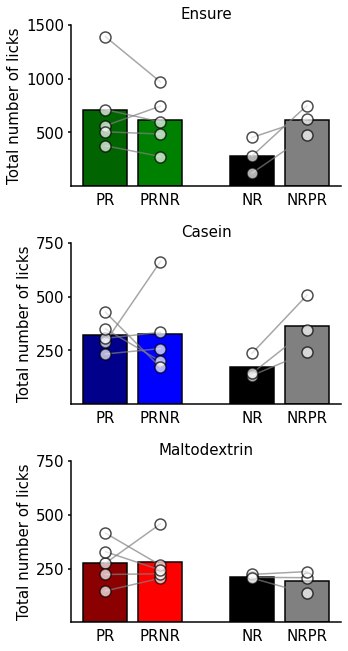

In [18]:
f,ax=plt.subplots(figsize=(5,10), ncols=1, nrows=3, sharey='row')
f.subplots_adjust(wspace=0.15,hspace=0.35, bottom=0.05, left=0.15)

colors_E=['Darkgreen','green','black', 'grey']
colors_C=['darkblue','blue','black', 'grey']
colors_M=['darkred','red','black', 'grey']
ax[0]= make_barscatter([[ensure_PR,ensure_PRNR],[ensure_NR,ensure_NRPR]], ax=ax[0], barfacecolor=colors_E)
ax[1]= make_barscatter([[cas_PR,cas_PRNR],[cas_NR,cas_NRPR]], ax=ax[1],barfacecolor= colors_C)
ax[2] = make_barscatter([[malt_PR,malt_PRNR],[malt_NR,malt_NRPR]], ax=ax[2],barfacecolor= colors_M)



ax[0].set_ylabel('Total number of licks',fontsize = 15)
ax[0].set_yticks([500,1000,1500])
ax[0].set_yticklabels([500,1000,1500], fontsize = 15)

ax[1].set_ylabel('Total number of licks',fontsize = 15)
ax[1].set_yticks([250,500,750])
ax[1].set_yticklabels([250,500,750], fontsize = 15)

ax[2].set_ylabel('Total number of licks',fontsize = 15)
ax[2].set_yticks([250,500,750])
ax[2].set_yticklabels([250,500,750], fontsize = 15)

ax[0].set_title('Ensure', fontsize =15)
ax[1].set_title('Casein', fontsize =15)
ax[2].set_title('Maltodextrin', fontsize =15)


f.savefig('C:\\Users\\mko102\\GitHub\\VGP\\output\\total_licks.png')

proteinpaired 

In [19]:
ppaired_NR=[]
ppaired_PR=[]

ppaired_NRPR=[]
ppaired_PRNR=[]


for mouse in mice: 
    temp_NR=[]
    temp_PR=[]
    
    temp_NRPR=[]
    temp_PRNR=[]
    
    for key in all_data.keys():
        d=all_data[key]
        if d['mouse']==mouse and d['solution']=='ppaired'and d['diet']== 'PR':
            temp_PR.append(d['total licks'])
        elif d['mouse']==mouse and d['solution']=='ppaired' and d['diet']== 'NR':
            temp_NR.append(d['total licks'])
        elif d['mouse']==mouse and d['solution']=='ppaired' and d['diet']== 'PRNR':
            temp_PRNR.append(d['total licks'])
        elif d['mouse']==mouse and d['solution']=='ppaired' and d['diet']== 'NRPR':
            temp_NRPR.append(d['total licks'])

                
    if len(temp_PR)> 0:
        ppaired_PR.append(np.mean(temp_PR))
    if len(temp_NR)>0:
        ppaired_NR.append(np.mean(temp_NR))
    if len(temp_PRNR)>0:
        ppaired_PRNR.append(np.mean(temp_PRNR))
    if len(temp_NRPR)>0:
        ppaired_NRPR.append(np.mean(temp_NRPR))
        
print('PR', ppaired_PR)
print('PRNR', ppaired_PRNR)
print('  ')
print('NR', ppaired_NR)
print('NRPR', ppaired_NRPR)

PR [385.0, 126.0, 477.0, 412.0, 277.0]
PRNR [355.0, 155.0, 294.0, 320.0]
  
NR [261.0, 195.0, 109.0]
NRPR [269.0, 241.0, 180.0]


In [20]:
mpaierd_NR=[]
mpaierd_PR=[]

mpaierd_NRPR=[]
mpaierd_PRNR=[]


for mouse in mice: 
    temp_NR=[]
    temp_PR=[]
    
    temp_NRPR=[]
    temp_PRNR=[]
    
    for key in all_data.keys():
        d=all_data[key]
        if d['mouse']==mouse and d['solution']=='mpaired'and d['diet']== 'PR':
            temp_PR.append(d['total licks'])
        elif d['mouse']==mouse and d['solution']=='mpaired' and d['diet']== 'NR':
            temp_NR.append(d['total licks'])
        elif d['mouse']==mouse and d['solution']=='mpaired' and d['diet']== 'PRNR':
            temp_PRNR.append(d['total licks'])
        elif d['mouse']==mouse and d['solution']=='mpaired' and d['diet']== 'NRPR':
            temp_NRPR.append(d['total licks'])

                
    if len(temp_PR)> 0:
        mpaierd_PR.append(np.mean(temp_PR))
    if len(temp_NR)>0:
        mpaierd_NR.append(np.mean(temp_NR))
    if len(temp_PRNR)>0:
        mpaierd_PRNR.append(np.mean(temp_PRNR))
    if len(temp_NRPR)>0:
        mpaierd_NRPR.append(np.mean(temp_NRPR))
        
print('PR', mpaierd_PR)
print('PRNR', mpaierd_PRNR)
print('  ')
print('NR', mpaierd_NR)
print('NRPR', mpaierd_NRPR)

PR [243.0, 174.0, 177.0, 373.0, 406.0]
PRNR [321.0, 31.0, 263.0, 346.0, 416.0]
  
NR [355.0, 195.0, 210.0]
NRPR [304.0, 171.0, 147.0]


C:\Users\mko102\Anaconda3\lib\site-packages\numpy\core\_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)


ValueError: x and y must have same first dimension, but have shapes (2,) and (5,)

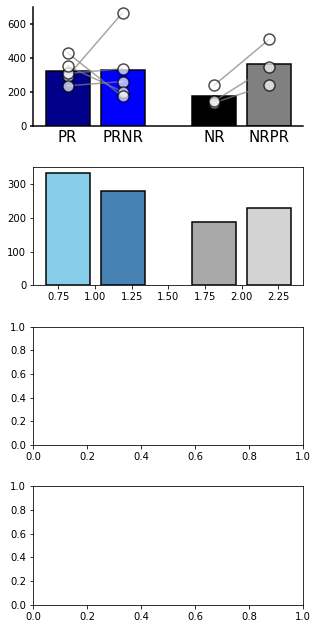

In [21]:
f,ax=plt.subplots(figsize=(5,10), ncols=1, nrows=4)
f.subplots_adjust(wspace=0.15,hspace=0.35, bottom=0.05, left=0.15)


colors_C=['darkblue','blue','black', 'grey']
colors_PP=['skyblue','steelblue','darkgrey','lightgrey']
colors_M=['darkred','red','black', 'grey']
colors_CP=['lightcoral','indianred','darkgrey','lightgrey']

ax[0]= make_barscatter([[cas_PR,cas_PRNR],[cas_NR,cas_NRPR]], ax=ax[0],barfacecolor= colors_C)
ax[1]= make_barscatter([[ppaired_PR,ppaired_PRNR],[ppaired_NR,ppaired_NRPR]], ax=ax[1],barfacecolor= colors_PP)
ax[2] = make_barscatter([[malt_PR,malt_PRNR],[malt_NR,malt_NRPR]], ax=ax[2],barfacecolor= colors_M)
ax[3] = make_barscatter([[mpaierd_PR,mpaierd_PRNR],[mpaierd_NR,mpaierd_NRPR]], ax=ax[3],barfacecolor= colors_CP)


ax[0].set_ylabel('# of licks',fontsize = 15)
ax[0].set_yticks([250,500,750])
ax[0].set_yticklabels([250,500,750], fontsize = 15)

ax[1].set_ylabel('# of licks',fontsize = 15)
ax[1].set_yticks([250,500,750])
ax[1].set_yticklabels([250,500,750], fontsize = 15)

ax[2].set_ylabel('# of licks',fontsize = 15)
ax[2].set_yticks([250,500,750])
ax[2].set_yticklabels([250,500,750], fontsize = 15)

ax[3].set_ylabel('# of licks',fontsize = 15)
ax[3].set_yticks([250,500,750])
ax[3].set_yticklabels([250,500,750], fontsize = 15)

ax[0].set_title('Protein', fontsize =15)
ax[1].set_title('Protein paired', fontsize =15)
ax[2].set_title('Carb', fontsize =15)
ax[3].set_title('Carb paired', fontsize =15)

f.savefig('C:\\Users\\mko102\\GitHub\\VGP\\output\\total_licks_koolaid.png')



## Licks per trial (all)

Baseline

In [22]:
baseline_NR=[]
baseline_PR=[]

for mouse in mice: 
    temp_NR=[]
    temp_PR=[]
    
    for key in all_data.keys():
        d=all_data[key]
        if d['mouse']==mouse and d['solution']=='Baseline'and d['diet']== 'PR':
            temp_PR.append(d['licks per trial'])
        elif d['mouse']==mouse and d['solution']=='Baseline' and d['diet']== 'NR':
            temp_NR.append(d['licks per trial'])

                
    if len(temp_PR)> 0:
        baseline_PR.append(np.mean(temp_PR))
    if len(temp_NR)>0:
        baseline_NR.append(np.mean(temp_NR))

In [23]:
print('PR',baseline_PR)
print('NR',baseline_NR)

PR [2.7579476756306023, 7.543081543081542, 19.995951417004047, 10.494548087571344, 21.53663375919474]
NR [10.444512195121952, 3.9015969410706255, 10.949343339587243]


Ensure

In [24]:
ensure_NR=[]
ensure_PR=[]

ensure_NRPR=[]
ensure_PRNR=[]


for mouse in mice: 
    temp_NR=[]
    temp_PR=[]
    
    temp_NRPR=[]
    temp_PRNR=[]
    
    for key in all_data.keys():
        d=all_data[key]
        if d['mouse']==mouse and d['solution']=='Ensure'and d['diet']== 'PR':
            temp_PR.append(d['licks per trial'])
        elif d['mouse']==mouse and d['solution']=='Ensure' and d['diet']== 'NR':
            temp_NR.append(d['licks per trial'])
        elif d['mouse']==mouse and d['solution']=='Ensure' and d['diet']== 'PRNR':
            temp_PRNR.append(d['licks per trial'])
        elif d['mouse']==mouse and d['solution']=='Ensure' and d['diet']== 'NRPR':
            temp_NRPR.append(d['licks per trial'])

                
    if len(temp_PR)> 0:
        ensure_PR.append(np.mean(temp_PR))
    if len(temp_NR)>0:
        ensure_NR.append(np.mean(temp_NR))
    if len(temp_PRNR)>0:
        ensure_PRNR.append(np.mean(temp_PRNR))
    if len(temp_NRPR)>0:
        ensure_NRPR.append(np.mean(temp_NRPR))
        
print('PR',ensure_PR)
print('PRNR', ensure_PRNR)
print('  ')
print('NR',ensure_NR)
print('NRPR', ensure_NRPR)

PR [6.975770218228498, 3.8492424242424246, 5.508072753804462, 8.010920177383591, 15.44890943575154]
PRNR [9.738633982820028, 2.4134146341463416, 6.346690590111643, 8.065740740740742, 15.108396858396858]
  
NR [1.2965645821871752, 4.117405867405867, 5.10534188034188]
NRPR [5.859744120613686, 11.449561403508772, 8.755578139114723]


Casein

In [25]:
cas_NR=[]
cas_PR=[]

cas_NRPR=[]
cas_PRNR=[]


for mouse in mice: 
    temp_NR=[]
    temp_PR=[]
    
    temp_NRPR=[]
    temp_PRNR=[]
    
    for key in all_data.keys():
        d=all_data[key]
        if d['mouse']==mouse and d['solution']=='Cas'and d['diet']== 'PR':
            temp_PR.append(d['licks per trial'])
        elif d['mouse']==mouse and d['solution']=='Cas' and d['diet']== 'NR':
            temp_NR.append(d['licks per trial'])
        elif d['mouse']==mouse and d['solution']=='Cas' and d['diet']== 'PRNR':
            temp_PRNR.append(d['licks per trial'])
        elif d['mouse']==mouse and d['solution']=='Cas' and d['diet']== 'NRPR':
            temp_NRPR.append(d['licks per trial'])

                
    if len(temp_PR)> 0:
        cas_PR.append(np.mean(temp_PR))
    if len(temp_NR)>0:
        cas_NR.append(np.mean(temp_NR))
    if len(temp_PRNR)>0:
        cas_PRNR.append(np.mean(temp_PRNR))
    if len(temp_NRPR)>0:
        cas_NRPR.append(np.mean(temp_NRPR))
        
        
print('PR',cas_PR)
print('PRNR', cas_PRNR)
print('  ')
print('NR',cas_NR)
print('NRPR', cas_NRPR)

PR [2.7364522417153996, 2.3086303939962476, 2.900877192982456, 4.231435231435231, 4.978778883183568]
PRNR [7.753508771929824, 2.4960156802262063, 3.625779625779626, 5.280555555555555, 1.7402027027027027]
  
NR [1.200404858299595, 1.2601779317604616, 2.537626116573485]
NRPR [3.005430242272347, 5.448717948717949, 7.268537768537769]


Maltodextrin

In [26]:
malt_NR=[]
malt_PR=[]

malt_NRPR=[]
malt_PRNR=[]


for mouse in mice: 
    temp_NR=[]
    temp_PR=[]
    
    temp_NRPR=[]
    temp_PRNR=[]
    
    for key in all_data.keys():
        d=all_data[key]
        if d['mouse']==mouse and d['solution']=='Malt.'and d['diet']== 'PR':
            temp_PR.append(d['licks per trial'])
        elif d['mouse']==mouse and d['solution']=='Malt.' and d['diet']== 'NR':
            temp_NR.append(d['licks per trial'])
        elif d['mouse']==mouse and d['solution']=='Malt.' and d['diet']== 'PRNR':
            temp_PRNR.append(d['licks per trial'])
        elif d['mouse']==mouse and d['solution']=='Malt.' and d['diet']== 'NRPR':
            temp_NRPR.append(d['licks per trial'])

                
    if len(temp_PR)> 0:
        malt_PR.append(np.mean(temp_PR))
    if len(temp_NR)>0:
        malt_NR.append(np.mean(temp_NR))
    if len(temp_PRNR)>0:
        malt_PRNR.append(np.mean(temp_PRNR))
    if len(temp_NRPR)>0:
        malt_NRPR.append(np.mean(temp_NRPR))
        
print('PR', malt_PR)
print('PRNR', malt_PRNR)
print('  ')
print('NR', malt_NR)
print('NRPR', malt_NRPR)

PR [3.5341130604288495, 1.5707317073170735, 2.482905982905983, 3.9434542422347296, 2.9451754385964914]
PRNR [4.4558060084375875, 2.1532677848467325, 1.5964714714714714, 2.569337979094077, 2.8080745341614906]
  
NR [1.5737080103359176, 2.361788617886179, 2.230958230958231]
NRPR [1.896049896049896, 1.7040791187132651, 1.04800853485064]


## Figures licks per trial

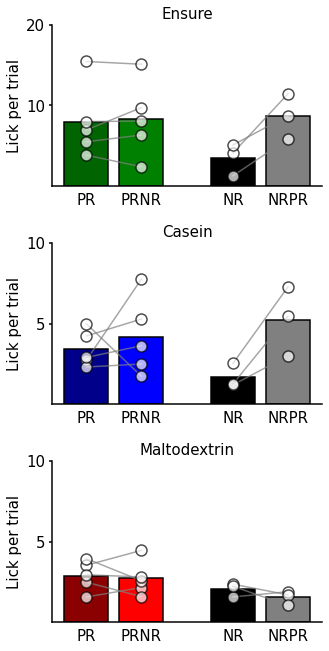

In [27]:
f,ax=plt.subplots(figsize=(5,10), ncols=1, nrows=3, sharey='row')
f.subplots_adjust(wspace=0.15,hspace=0.35, bottom=0.05, left=0.15)

colors_E=['Darkgreen','green','black', 'grey']
colors_C=['darkblue','blue','black', 'grey']
colors_M=['darkred','red','black', 'grey']
ax[0]= make_barscatter([[ensure_PR,ensure_PRNR],[ensure_NR,ensure_NRPR]], ax=ax[0], barfacecolor=colors_E)
ax[1]= make_barscatter([[cas_PR,cas_PRNR],[cas_NR,cas_NRPR]], ax=ax[1],barfacecolor= colors_C)
ax[2] = make_barscatter([[malt_PR,malt_PRNR],[malt_NR,malt_NRPR]], ax=ax[2],barfacecolor= colors_M)



ax[0].set_ylabel('Lick per trial',fontsize = 15)
ax[0].set_yticks([10,20])
ax[0].set_yticklabels([10,20], fontsize = 15)

ax[1].set_ylabel('Lick per trial',fontsize = 15)
ax[1].set_yticks([5,10])
ax[1].set_yticklabels([5,10], fontsize = 15)

ax[2].set_ylabel('Lick per trial',fontsize = 15)
ax[2].set_yticks([5,10])
ax[2].set_yticklabels([5,10], fontsize = 15)

ax[0].set_title('Ensure', fontsize =15)
ax[1].set_title('Casein', fontsize =15)
ax[2].set_title('Maltodextrin', fontsize =15)


f.savefig('C:\\Users\\mko102\\GitHub\\VGP\\output\\licks_per_trial.png')

## Number of hit trials

In [28]:
baseline_NR=[]
baseline_PR=[]

for mouse in mice: 
    temp_NR=[]
    temp_PR=[]
    
    for key in all_data.keys():
        d=all_data[key]
        if d['mouse']==mouse and d['solution']=='Baseline'and d['diet']== 'PR':
            temp_PR.append(d['hit trial'])
        elif d['mouse']==mouse and d['solution']=='Baseline' and d['diet']== 'NR':
            temp_NR.append(d['hit trial'])

                
    if len(temp_PR)> 0:
        baseline_PR.append(np.mean(temp_PR))
    if len(temp_NR)>0:
        baseline_NR.append(np.mean(temp_NR))

In [29]:
print('PR',baseline_PR)
print('NR',baseline_NR)

PR [27.0, 33.333333333333336, 36.666666666666664, 36.333333333333336, 36.666666666666664]
NR [31.333333333333332, 18.0, 39.0]


Ensure

In [30]:
ensure_NR=[]
ensure_PR=[]

ensure_NRPR=[]
ensure_PRNR=[]


for mouse in mice: 
    temp_NR=[]
    temp_PR=[]
    
    temp_NRPR=[]
    temp_PRNR=[]
    
    for key in all_data.keys():
        d=all_data[key]
        if d['mouse']==mouse and d['solution']=='Ensure'and d['diet']== 'PR':
            temp_PR.append(d['hit trial'])
        elif d['mouse']==mouse and d['solution']=='Ensure' and d['diet']== 'NR':
            temp_NR.append(d['hit trial'])
        elif d['mouse']==mouse and d['solution']=='Ensure' and d['diet']== 'PRNR':
            temp_PRNR.append(d['hit trial'])
        elif d['mouse']==mouse and d['solution']=='Ensure' and d['diet']== 'NRPR':
            temp_NRPR.append(d['hit trial'])

                
    if len(temp_PR)> 0:
        ensure_PR.append(np.mean(temp_PR))
    if len(temp_NR)>0:
        ensure_NR.append(np.mean(temp_NR))
    if len(temp_PRNR)>0:
        ensure_PRNR.append(np.mean(temp_PRNR))
    if len(temp_NRPR)>0:
        ensure_NRPR.append(np.mean(temp_NRPR))
        
print('PR',ensure_PR)
print('PRNR', ensure_PRNR)
print('  ')
print('NR',ensure_NR)
print('NRPR', ensure_NRPR)

PR [26.333333333333332, 21.0, 24.0, 40.333333333333336, 35.0]
PRNR [39.333333333333336, 7.666666666666667, 29.0, 28.333333333333332, 35.0]
  
NR [12.333333333333334, 22.333333333333332, 27.333333333333332]
NRPR [31.0, 35.333333333333336, 36.0]


Casein

In [31]:
cas_NR=[]
cas_PR=[]

cas_NRPR=[]
cas_PRNR=[]


for mouse in mice: 
    temp_NR=[]
    temp_PR=[]
    
    temp_NRPR=[]
    temp_PRNR=[]
    
    for key in all_data.keys():
        d=all_data[key]
        if d['mouse']==mouse and d['solution']=='Cas'and d['diet']== 'PR':
            temp_PR.append(d['hit trial'])
        elif d['mouse']==mouse and d['solution']=='Cas' and d['diet']== 'NR':
            temp_NR.append(d['hit trial'])
        elif d['mouse']==mouse and d['solution']=='Cas' and d['diet']== 'PRNR':
            temp_PRNR.append(d['hit trial'])
        elif d['mouse']==mouse and d['solution']=='Cas' and d['diet']== 'NRPR':
            temp_NRPR.append(d['hit trial'])

                
    if len(temp_PR)> 0:
        cas_PR.append(np.mean(temp_PR))
    if len(temp_NR)>0:
        cas_NR.append(np.mean(temp_NR))
    if len(temp_PRNR)>0:
        cas_PRNR.append(np.mean(temp_PRNR))
    if len(temp_NRPR)>0:
        cas_NRPR.append(np.mean(temp_NRPR))
        
        
print('PR',cas_PR)
print('PRNR', cas_PRNR)
print('  ')
print('NR',cas_NR)
print('NRPR', cas_NRPR)

PR [17.666666666666668, 12.666666666666666, 15.333333333333334, 21.333333333333332, 22.0]
PRNR [38.666666666666664, 9.666666666666666, 24.0, 10.5, 17.0]
  
NR [11.333333333333334, 12.333333333333334, 17.333333333333332]
NRPR [17.0, 29.666666666666668, 29.0]


Maltodextrin

In [32]:
malt_NR=[]
malt_PR=[]

malt_NRPR=[]
malt_PRNR=[]


for mouse in mice: 
    temp_NR=[]
    temp_PR=[]
    
    temp_NRPR=[]
    temp_PRNR=[]
    
    for key in all_data.keys():
        d=all_data[key]
        if d['mouse']==mouse and d['solution']=='Malt.'and d['diet']== 'PR':
            temp_PR.append(d['hit trial'])
        elif d['mouse']==mouse and d['solution']=='Malt.' and d['diet']== 'NR':
            temp_NR.append(d['hit trial'])
        elif d['mouse']==mouse and d['solution']=='Malt.' and d['diet']== 'PRNR':
            temp_PRNR.append(d['hit trial'])
        elif d['mouse']==mouse and d['solution']=='Malt.' and d['diet']== 'NRPR':
            temp_NRPR.append(d['hit trial'])

                
    if len(temp_PR)> 0:
        malt_PR.append(np.mean(temp_PR))
    if len(temp_NR)>0:
        malt_NR.append(np.mean(temp_NR))
    if len(temp_PRNR)>0:
        malt_PRNR.append(np.mean(temp_PRNR))
    if len(temp_NRPR)>0:
        malt_NRPR.append(np.mean(temp_NRPR))
        
print('PR', malt_PR)
print('PRNR', malt_PRNR)
print('  ')
print('NR', malt_NR)
print('NRPR', malt_NRPR)

PR [18.666666666666668, 12.666666666666666, 14.0, 23.333333333333332, 14.333333333333334]
PRNR [27.333333333333332, 19.0, 13.5, 19.5, 16.5]
  
NR [18.666666666666668, 17.0, 13.333333333333334]
NRPR [16.0, 21.0, 11.5]


## Figures licks per trial

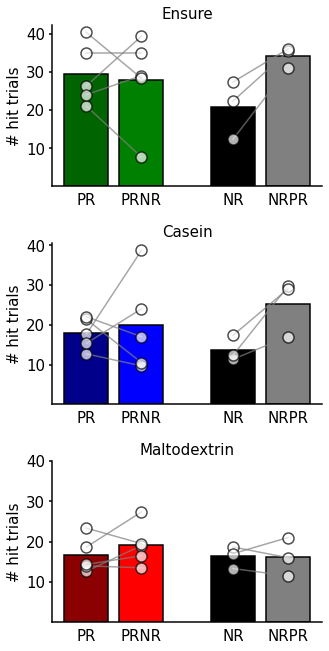

In [33]:
f,ax=plt.subplots(figsize=(5,10), ncols=1, nrows=3, sharey='row')
f.subplots_adjust(wspace=0.15,hspace=0.35, bottom=0.05, left=0.15)

colors_E=['Darkgreen','green','black', 'grey']
colors_C=['darkblue','blue','black', 'grey']
colors_M=['darkred','red','black', 'grey']
ax[0]= make_barscatter([[ensure_PR,ensure_PRNR],[ensure_NR,ensure_NRPR]], ax=ax[0], barfacecolor=colors_E)
ax[1]= make_barscatter([[cas_PR,cas_PRNR],[cas_NR,cas_NRPR]], ax=ax[1],barfacecolor= colors_C)
ax[2] = make_barscatter([[malt_PR,malt_PRNR],[malt_NR,malt_NRPR]], ax=ax[2],barfacecolor= colors_M)



ax[0].set_ylabel('# hit trials',fontsize = 15)
ax[0].set_yticks([10,20,30,40])
ax[0].set_yticklabels([10,20,30,40], fontsize = 15)

ax[1].set_ylabel('# hit trials',fontsize = 15)
ax[1].set_yticks([10,20,30,40])
ax[1].set_yticklabels([10,20,30,40], fontsize = 15)

ax[2].set_ylabel('# hit trials',fontsize = 15)
ax[2].set_yticks([10,20,30,40])
ax[2].set_yticklabels([10,20,30,40], fontsize = 15)

ax[0].set_title('Ensure', fontsize =15)
ax[1].set_title('Casein', fontsize =15)
ax[2].set_title('Maltodextrin', fontsize =15)


f.savefig('C:\\Users\\mko102\\GitHub\\VGP\\output\\lick_hit_trial.png')

## Latency to first lick

In [34]:
baseline_NR=[]
baseline_PR=[]

for mouse in mice: 
    temp_NR=[]
    temp_PR=[]
    
    for key in all_data.keys():
        d=all_data[key]
        if d['mouse']==mouse and d['solution']=='Baseline'and d['diet']== 'PR':
            temp_PR.append(d['latency'])
        elif d['mouse']==mouse and d['solution']=='Baseline' and d['diet']== 'NR':
            temp_NR.append(d['latency'])

                
    if len(temp_PR)> 0:
        baseline_PR.append(np.mean(temp_PR))
    if len(temp_NR)>0:
        baseline_NR.append(np.mean(temp_NR))

In [35]:
print('PR',baseline_PR)
print('NR',baseline_NR)

PR [28.75308641975309, 23.156555525435977, 22.979468942626838, 22.08265934607398, 19.81091617933723]
NR [23.3158670597695, 35.688795518207286, 20.188061617458278]


Ensure

In [36]:
ensure_NR=[]
ensure_PR=[]

ensure_NRPR=[]
ensure_PRNR=[]


for mouse in mice: 
    temp_NR=[]
    temp_PR=[]
    
    temp_NRPR=[]
    temp_PRNR=[]
    
    for key in all_data.keys():
        d=all_data[key]
        if d['mouse']==mouse and d['solution']=='Ensure'and d['diet']== 'PR':
            temp_PR.append(d['latency'])
        elif d['mouse']==mouse and d['solution']=='Ensure' and d['diet']== 'NR':
            temp_NR.append(d['latency'])
        elif d['mouse']==mouse and d['solution']=='Ensure' and d['diet']== 'PRNR':
            temp_PRNR.append(d['latency'])
        elif d['mouse']==mouse and d['solution']=='Ensure' and d['diet']== 'NRPR':
            temp_NRPR.append(d['latency'])

                
    if len(temp_PR)> 0:
        ensure_PR.append(np.mean(temp_PR))
    if len(temp_NR)>0:
        ensure_NR.append(np.mean(temp_NR))
    if len(temp_PRNR)>0:
        ensure_PRNR.append(np.mean(temp_PRNR))
    if len(temp_NRPR)>0:
        ensure_NRPR.append(np.mean(temp_NRPR))
        
print('PR',ensure_PR)
print('PRNR', ensure_PRNR)
print('  ')
print('NR',ensure_NR)
print('NRPR', ensure_NRPR)

PR [28.44069069069069, 29.86538241027405, 23.093177093177093, 26.507723577235776, 19.030550514216575]
PRNR [26.597423004399747, 29.88888888888889, 29.407692307692304, 28.07794427794428, 20.378736827012688]
  
NR [29.8, 37.53402777777777, 23.77977747332586]
NRPR [31.951992753623188, 26.547953216374268, 26.32146603724102]


Casein

In [37]:
cas_NR=[]
cas_PR=[]
cas_PR_all=[]

cas_NRPR=[]
cas_PRNR=[]


for mouse in mice: 
    temp_NR=[]
    temp_PR=[]
    temp_PR_all=[]
    
    temp_NRPR=[]
    temp_PRNR=[]
    
    for key in all_data.keys():
        d=all_data[key]
        if d['mouse']==mouse and d['solution']=='Cas'and d['diet']== 'PR':
            temp_PR.append(d['latency'])
#             temp_PR_all.append(d['latency all'])
        elif d['mouse']==mouse and d['solution']=='Cas' and d['diet']== 'NR':
            temp_NR.append(d['latency'])
        elif d['mouse']==mouse and d['solution']=='Cas' and d['diet']== 'PRNR':
            temp_PRNR.append(d['latency'])
        elif d['mouse']==mouse and d['solution']=='Cas' and d['diet']== 'NRPR':
            temp_NRPR.append(d['latency'])

                
    if len(temp_PR)> 0:
        cas_PR.append(np.mean(temp_PR))
#         cas_PR_all.append(temp_PR_all)
    if len(temp_NR)>0:
        cas_NR.append(np.mean(temp_NR))
    if len(temp_PRNR)>0:
        cas_PRNR.append(np.mean(temp_PRNR))
    if len(temp_NRPR)>0:
        cas_NRPR.append(np.mean(temp_NRPR))
        
        
        
print('PR',cas_PR)
print('PRNR', cas_PRNR)
print('  ')
print('NR',cas_NR)
print('NRPR', cas_NRPR)

PR [35.41020114942528, 34.125, 33.15299773755657, 40.4324074074074, 29.187207602339182]
PRNR [31.890902667373258, 30.24848484848485, 42.02182163187856, 27.39285714285714, 37.36363636363636]
  
NR [28.191666666666666, 44.989417989417994, 27.41956043956044]
NRPR [39.520880632954935, 38.17266067266067, 27.316363636363636]


Maltodextrin

In [38]:
malt_NR=[]
malt_PR=[]

malt_NRPR=[]
malt_PRNR=[]


for mouse in mice: 
    temp_NR=[]
    temp_PR=[]
    
    temp_NRPR=[]
    temp_PRNR=[]
    
    for key in all_data.keys():
        d=all_data[key]
        if d['mouse']==mouse and d['solution']=='Malt.'and d['diet']== 'PR':
            temp_PR.append(d['latency'])
        elif d['mouse']==mouse and d['solution']=='Malt.' and d['diet']== 'NR':
            temp_NR.append(d['latency'])
        elif d['mouse']==mouse and d['solution']=='Malt.' and d['diet']== 'PRNR':
            temp_PRNR.append(d['hit trial'])
        elif d['mouse']==mouse and d['solution']=='Malt.' and d['diet']== 'NRPR':
            temp_NRPR.append(d['latency'])

                
    if len(temp_PR)> 0:
        malt_PR.append(np.mean(temp_PR))
    if len(temp_NR)>0:
        malt_NR.append(np.mean(temp_NR))
    if len(temp_PRNR)>0:
        malt_PRNR.append(np.mean(temp_PRNR))
    if len(temp_NRPR)>0:
        malt_NRPR.append(np.mean(temp_NRPR))
        
print('PR', malt_PR)
print('PRNR', malt_PRNR)
print('  ')
print('NR', malt_NR)
print('NRPR', malt_NRPR)

PR [27.145146520146522, 40.031590413943356, 30.694444444444443, 26.46385640025991, 37.738344988344984]
PRNR [27.333333333333332, 19.0, 13.5, 19.5, 16.5]
  
NR [28.71759259259259, 33.21969696969697, 37.299572649572646]
NRPR [30.745238095238097, 24.871794871794872, 22.53333333333333]


## Figures Latency

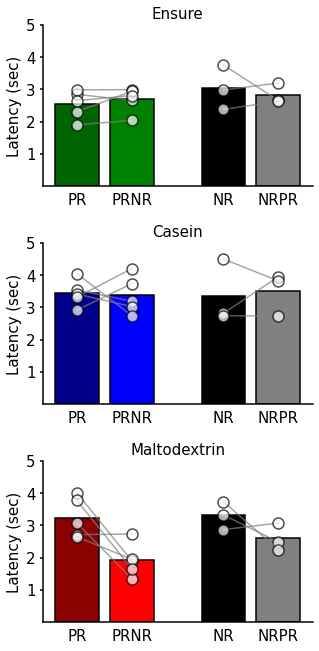

In [39]:
f,ax=plt.subplots(figsize=(5,10), ncols=1, nrows=3, sharey='row')
f.subplots_adjust(wspace=0.15,hspace=0.35, bottom=0.05, left=0.15)

colors_E=['Darkgreen','green','black', 'grey']
colors_C=['darkblue','blue','black', 'grey']
colors_M=['darkred','red','black', 'grey']
ax[0]= make_barscatter([[ensure_PR,ensure_PRNR],[ensure_NR,ensure_NRPR]], ax=ax[0], barfacecolor=colors_E)
ax[1]= make_barscatter([[cas_PR,cas_PRNR],[cas_NR,cas_NRPR]], ax=ax[1],barfacecolor= colors_C)
ax[2] = make_barscatter([[malt_PR,malt_PRNR],[malt_NR,malt_NRPR]], ax=ax[2],barfacecolor= colors_M)



ax[0].set_ylabel('Latency (sec)',fontsize = 15)
ax[0].set_yticks([10,20,30,40,50])
ax[0].set_yticklabels([1,2,3,4,5], fontsize = 15)

ax[1].set_ylabel('Latency (sec)',fontsize = 15)
ax[1].set_yticks([10,20,30,40,50])
ax[1].set_yticklabels([1,2,3,4,5], fontsize = 15)

ax[2].set_ylabel('Latency (sec)',fontsize = 15)
ax[2].set_yticks([10,20,30,40,50])
ax[2].set_yticklabels([1,2,3,4,5], fontsize = 15)

ax[0].set_title('Ensure', fontsize =15)
ax[1].set_title('Casein', fontsize =15)
ax[2].set_title('Maltodextrin', fontsize =15)


f.savefig('C:\\Users\\mko102\\GitHub\\VGP\\output\\latency.png')

In [41]:
cas_PR_S1=[]
cas_NR_S1=[]


cas_PRNR_S1=[]
cas_NRPR_S1=[]


for mouse in mice: 
    temp_NR=[]
    temp_PR=[]

    
    temp_NRPR=[]
    temp_PRNR=[]
    
    for key in all_data.keys():
        d=all_data[key]
        if d['mouse']==mouse and d['solution']=='Cas'and d['diet']== 'PR' and d['session']=='S1':
            temp_PR.append(d['latency'])
        elif d['mouse']==mouse and d['solution']=='Cas' and d['diet']== 'NR' and d['session']=='S1':
            temp_NR.append(d['latency'])
        elif d['mouse']==mouse and d['solution']=='Cas' and d['diet']== 'PRNR' and d['session']=='S1':
            temp_PRNR.append(d['latency'])
        elif d['mouse']==mouse and d['solution']=='Cas' and d['diet']== 'NRPR' and d['session']=='S1':
            temp_NRPR.append(d['latency'])

                
    if len(temp_PR)> 0:
        cas_PR_S1.append(np.mean(temp_PR))
    if len(temp_NR)>0:
        cas_NR_S1.append(np.mean(temp_NR))
    if len(temp_PRNR)>0:
        cas_PRNR_S1.append(np.mean(temp_PRNR))
    if len(temp_NRPR)>0:
        cas_NRPR_S1.append(np.mean(temp_NRPR))
        
        
        
print('PR',cas_PR_S1)
print('PRNR', cas_PRNR_S1)
print('  ')
print('NR',cas_NR_S1)
print('NRPR', cas_NRPR_S1)

PR [27.79310344827586, 33.0, 29.1875, 48.45, 21.3125]
PRNR [37.94117647058823, 38.54545454545455, 32.16129032258065, 17.428571428571427, 38.5]
  
NR [26.45, 41.111111111111114, 19.44]
NRPR [39.411764705882355, 34.54545454545455, 28.36]


In [42]:
cas_PR_S2=[]
cas_NR_S2=[]


cas_PRNR_S2=[]
cas_NRPR_S2=[]


for mouse in mice: 
    temp_NR=[]
    temp_PR=[]

    
    temp_NRPR=[]
    temp_PRNR=[]
    
    for key in all_data.keys():
        d=all_data[key]
        if d['mouse']==mouse and d['solution']=='Cas'and d['diet']== 'PR' and d['session']=='S2':
            temp_PR.append(d['latency'])
        elif d['mouse']==mouse and d['solution']=='Cas' and d['diet']== 'NR' and d['session']=='S2':
            temp_NR.append(d['latency'])
        elif d['mouse']==mouse and d['solution']=='Cas' and d['diet']== 'PRNR' and d['session']=='S2':
            temp_PRNR.append(d['latency'])
        elif d['mouse']==mouse and d['solution']=='Cas' and d['diet']== 'NRPR' and d['session']=='S2':
            temp_NRPR.append(d['latency'])

                
    if len(temp_PR)> 0:
        cas_PR_S2.append(np.mean(temp_PR))
    if len(temp_NR)>0:
        cas_NR_S2.append(np.mean(temp_NR))
    if len(temp_PRNR)>0:
        cas_PRNR_S2.append(np.mean(temp_PRNR))
    if len(temp_NRPR)>0:
        cas_NRPR_S2.append(np.mean(temp_NRPR))
        
        
        
print('PR',cas_PR_S2)
print('PRNR', cas_PRNR_S2)
print('  ')
print('NR',cas_NR_S2)
print('NRPR', cas_NRPR_S2)

PR [33.1875, 40.875, 37.11764705882353, 46.625, 32.31578947368421]
PRNR [32.86486486486486, 29.7, 51.88235294117647, 37.357142857142854, 36.22727272727273]
  
NR [27.5, 33.714285714285715, 36.357142857142854]
NRPR [38.46666666666667, 31.615384615384617, 26.272727272727273]


In [43]:
cas_PR_S3=[]
cas_NR_S3=[]

cas_PRNR_S3=[]
cas_NRPR_S3=[]


for mouse in mice: 
    temp_NR=[]
    temp_PR=[]

    
    temp_NRPR=[]
    temp_PRNR=[]
    
    for key in all_data.keys():
        d=all_data[key]
        if d['mouse']==mouse and d['solution']=='Cas'and d['diet']== 'PR' and d['session']=='S3':
            temp_PR.append(d['latency'])
        elif d['mouse']==mouse and d['solution']=='Cas' and d['diet']== 'NR' and d['session']=='S3':
            temp_NR.append(d['latency'])
        elif d['mouse']==mouse and d['solution']=='Cas' and d['diet']== 'PRNR' and d['session']=='S3':
            temp_PRNR.append(d['latency'])
        elif d['mouse']==mouse and d['solution']=='Cas' and d['diet']== 'NRPR' and d['session']=='S3':
            temp_NRPR.append(d['latency'])

                
    if len(temp_PR)> 0:
        cas_PR_S3.append(np.mean(temp_PR))
    if len(temp_NR)>0:
        cas_NR_S3.append(np.mean(temp_NR))
    if len(temp_PRNR)>0:
        cas_PRNR_S3.append(np.mean(temp_PRNR))
    if len(temp_NRPR)>0:
        cas_NRPR_S3.append(np.mean(temp_NRPR))
        
        
        
print('PR',cas_PR_S3)
print('PRNR', cas_PRNR_S3)
print('  ')
print('NR',cas_NR_S3)
print('NRPR', cas_NRPR_S3)

PR [45.25, 28.5, 33.15384615384615, 26.22222222222222, 33.93333333333333]
PRNR [24.866666666666667, 22.5]
  
NR [30.625, 60.142857142857146, 26.46153846153846]
NRPR [40.68421052631579, 48.357142857142854]


## Cumulative licks Casein

Text(0.5, 0, 'Time (frames)')

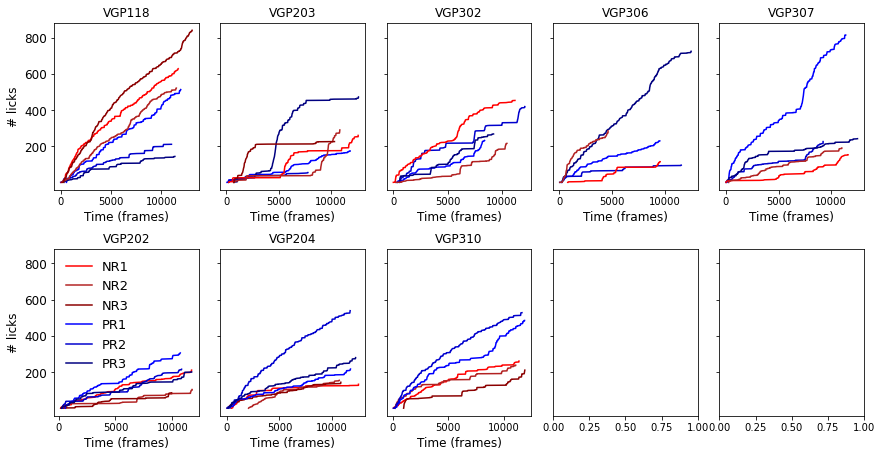

In [58]:
licks_118=[]
numbers_118=[]
session_118=[]

licks_202=[]
numbers_202=[]
session_202=[]

licks_203=[]
numbers_203=[]
session_203=[]

licks_204=[]
numbers_204=[]
session_204=[]

licks_302=[]
numbers_302=[]
session_302=[]

licks_310=[]
numbers_310=[]
session_310=[]

licks_306=[]
numbers_306=[]
session_306=[]

licks_307=[]
numbers_307=[]
session_307=[]
# cas_NRPR=[]
# cas_PRNR=[]


 
for key in all_data.keys():
    d=all_data[key]
    if d['mouse']=='VGP118'and d['solution']=='Cas':
        licks_118.append(d['licks_fn'])
        numbers_118.append([number for number in range(1,(len(d['licks_fn'])+1))])
        session_118.append(d['session'])
    elif d['mouse']=='VGP202'and d['solution']=='Cas':
        licks_202.append(d['licks_fn'])
        numbers_202.append([number for number in range(1,(len(d['licks_fn'])+1))])
        session_202.append(d['session'])
    elif d['mouse']=='VGP203'and d['solution']=='Cas':
        licks_203.append(d['licks_fn'])
        numbers_203.append([number for number in range(1,(len(d['licks_fn'])+1))])
        session_203.append(d['session'])
        
    elif d['mouse']=='VGP204'and d['solution']=='Cas':
        licks_204.append(d['licks_fn'])
        numbers_204.append([number for number in range(1,(len(d['licks_fn'])+1))])
        session_204.append(d['session'])
        
    elif d['mouse']=='VGP302'and d['solution']=='Cas':
        licks_302.append(d['licks_fn'])
        numbers_302.append([number for number in range(1,(len(d['licks_fn'])+1))])
        session_302.append(d['session'])
        
    elif d['mouse']=='VGP310'and d['solution']=='Cas':
        licks_310.append(d['licks_fn'])
        numbers_310.append([number for number in range(1,(len(d['licks_fn'])+1))])
        session_310.append(d['session'])
        
    elif d['mouse']=='VGP306'and d['solution']=='Cas':
        licks_306.append(d['licks_fn'])
        numbers_306.append([number for number in range(1,(len(d['licks_fn'])+1))])
        session_306.append(d['session'])
        
    elif d['mouse']=='VGP307'and d['solution']=='Cas':
        licks_307.append(d['licks_fn'])
        numbers_307.append([number for number in range(1,(len(d['licks_fn'])+1))])
        session_307.append(d['session'])


f, ax= plt.subplots(figsize=[15,7],ncols=5,nrows=2, sharey=True )
f.subplots_adjust(wspace=0.15,hspace=0.35, bottom=0.1, left=0.15)
colorPR=['b','mediumblue', 'navy', 'red', 'firebrick', 'darkred']
colorNR=['red', 'firebrick', 'darkred','b','mediumblue', 'navy']
handlesPR=['PR1', 'PR2', 'PR3', 'NR1', 'NR2', 'NR3'] 
handlesNR=['NR1', 'NR2', 'NR3','PR1', 'PR2', 'PR3'] 


for session, n,c in zip(licks_118,numbers_118,colorPR):
    ax[0,0].plot(session,n,c=c)
    
for session, n,c in zip(licks_203,numbers_203,colorPR):
    ax[0,1].plot(session,n,c=c)
    
for session, n,c in zip(licks_302,numbers_302,colorPR):
    ax[0,2].plot(session,n,c=c)
    
for session, n,c in zip(licks_306,numbers_306,colorPR):
    ax[0,3].plot(session,n,c=c)
    
for session, n,c in zip(licks_307,numbers_307,colorPR):
    ax[0,4].plot(session,n,c=c)
    
    
    
    
for session, n,c in zip(licks_202,numbers_202,colorNR):
    ax[1,0].plot(session,n,c=c)
    
for session, n,c in zip(licks_204,numbers_204,colorNR):
    ax[1,1].plot(session,n,c=c)
    
for session, n,c in zip(licks_310,numbers_310,colorNR):
    ax[1,2].plot(session,n,c=c)

# ax[0,0].legend(handlesPR, fontsize=13,frameon = False)
ax[1,0].legend(handlesNR, fontsize=13,frameon = False)


ax[0,0].set_title('VGP118', fontsize =12)
ax[0,1].set_title('VGP203', fontsize =12)
ax[0,2].set_title('VGP302', fontsize =12)
ax[0,3].set_title('VGP306', fontsize =12)
ax[0,4].set_title('VGP307', fontsize =12)
ax[1,0].set_title('VGP202', fontsize =12)
ax[1,1].set_title('VGP204', fontsize =12)
ax[1,2].set_title('VGP310', fontsize =12)


ax[0,0].set_ylabel('# licks',fontsize = 12)
ax[0,0].set_yticks([200,400,600,800])
ax[0,0].set_yticklabels([200,400,600,800], fontsize = 12)

ax[1,0].set_ylabel('# licks',fontsize = 12)
ax[1,0].set_yticks([200,400,600,800])
ax[1,0].set_yticklabels([200,400,600,800], fontsize = 12)


ax[0,0].set_xlabel('Time (frames)', fontsize = 12)
ax[0,1].set_xlabel('Time (frames)', fontsize = 12)
ax[0,2].set_xlabel('Time (frames)', fontsize = 12)
ax[0,3].set_xlabel('Time (frames)', fontsize = 12)
ax[0,4].set_xlabel('Time (frames)', fontsize = 12)


ax[1,0].set_xlabel('Time (frames)', fontsize = 12)
ax[1,1].set_xlabel('Time (frames)', fontsize = 12)
ax[1,2].set_xlabel('Time (frames)', fontsize = 12)



## Cumulative licks Maltodextrin

In [ ]:
licks_118=[]
numbers_118=[]
session_118=[]

licks_202=[]
numbers_202=[]
session_202=[]

licks_203=[]
numbers_203=[]
session_203=[]

licks_204=[]
numbers_204=[]
session_204=[]

licks_302=[]
numbers_302=[]
session_302=[]

licks_310=[]
numbers_310=[]
session_310=[]

licks_306=[]
numbers_306=[]
session_306=[]

licks_307=[]
numbers_307=[]
session_307=[]
# cas_NRPR=[]
# cas_PRNR=[]


 
for key in all_data.keys():
    d=all_data[key]
    if d['mouse']=='VGP118'and d['solution']=='Malt.':
        licks_118.append(d['licks_fn'])
        numbers_118.append([number for number in range(1,(len(d['licks_fn'])+1))])
        session_118.append(d['session'])
    elif d['mouse']=='VGP202'and d['solution']=='Malt.':
        licks_202.append(d['licks_fn'])
        numbers_202.append([number for number in range(1,(len(d['licks_fn'])+1))])
        session_202.append(d['session'])
    elif d['mouse']=='VGP203'and d['solution']=='Malt.':
        licks_203.append(d['licks_fn'])
        numbers_203.append([number for number in range(1,(len(d['licks_fn'])+1))])
        session_203.append(d['session'])
        
    elif d['mouse']=='VGP204'and d['solution']=='Malt.':
        licks_204.append(d['licks_fn'])
        numbers_204.append([number for number in range(1,(len(d['licks_fn'])+1))])
        session_204.append(d['session'])
        
    elif d['mouse']=='VGP302'and d['solution']=='Malt.':
        licks_302.append(d['licks_fn'])
        numbers_302.append([number for number in range(1,(len(d['licks_fn'])+1))])
        session_302.append(d['session'])
        
    elif d['mouse']=='VGP310'and d['solution']=='Malt.':
        licks_310.append(d['licks_fn'])
        numbers_310.append([number for number in range(1,(len(d['licks_fn'])+1))])
        session_310.append(d['session'])
        
    elif d['mouse']=='VGP306'and d['solution']=='Malt.':
        licks_306.append(d['licks_fn'])
        numbers_306.append([number for number in range(1,(len(d['licks_fn'])+1))])
        session_306.append(d['session'])
        
    elif d['mouse']=='VGP307'and d['solution']=='Malt.':
        licks_307.append(d['licks_fn'])
        numbers_307.append([number for number in range(1,(len(d['licks_fn'])+1))])
        session_307.append(d['session'])


f, ax= plt.subplots(figsize=[15,7],ncols=5,nrows=2, sharey=True )
f.subplots_adjust(wspace=0.15,hspace=0.35, bottom=0.1, left=0.15)
colorPR=['lightgreen','green', 'darkgreen', 'red', 'firebrick', 'darkred']
colorNR=['red', 'firebrick', 'darkred','lightgreen','green', 'darkgreen']
handlesPR=['PR1', 'PR2', 'PR3', 'NR1', 'NR2', 'NR3'] 
handlesNR=['NR1', 'NR2', 'NR3','PR1', 'PR2', 'PR3'] 


for session, n,c in zip(licks_118,numbers_118,colorPR):
    ax[0,0].plot(session,n,c=c)
    
for session, n,c in zip(licks_203,numbers_203,colorPR):
    ax[0,1].plot(session,n,c=c)
    
for session, n,c in zip(licks_302,numbers_302,colorPR):
    ax[0,2].plot(session,n,c=c)
    
for session, n,c in zip(licks_306,numbers_306,colorPR):
    ax[0,3].plot(session,n,c=c)
    
for session, n,c in zip(licks_307,numbers_307,colorPR):
    ax[0,4].plot(session,n,c=c)
    
    
    
    
for session, n,c in zip(licks_202,numbers_202,colorNR):
    ax[1,0].plot(session,n,c=c)
    
for session, n,c in zip(licks_204,numbers_204,colorNR):
    ax[1,1].plot(session,n,c=c)
    
for session, n,c in zip(licks_310,numbers_310,colorNR):
    ax[1,2].plot(session,n,c=c)

# ax[0,0].legend(handlesPR, fontsize=13,frameon = False)
ax[1,0].legend(handlesNR, fontsize=13,frameon = False)


ax[0,0].set_title('VGP118', fontsize =12)
ax[0,1].set_title('VGP203', fontsize =12)
ax[0,2].set_title('VGP302', fontsize =12)
ax[0,3].set_title('VGP306', fontsize =12)
ax[0,4].set_title('VGP307', fontsize =12)
ax[1,0].set_title('VGP202', fontsize =12)
ax[1,1].set_title('VGP204', fontsize =12)
ax[1,2].set_title('VGP310', fontsize =12)


ax[0,0].set_ylabel('# licks',fontsize = 12)
ax[0,0].set_yticks([200,400,600,800])
ax[0,0].set_yticklabels([200,400,600,800], fontsize = 12)

ax[1,0].set_ylabel('# licks',fontsize = 12)
ax[1,0].set_yticks([200,400,600,800])
ax[1,0].set_yticklabels([200,400,600,800], fontsize = 12)


ax[0,0].set_xlabel('Time (frames)', fontsize = 12)
ax[0,1].set_xlabel('Time (frames)', fontsize = 12)
ax[0,2].set_xlabel('Time (frames)', fontsize = 12)
ax[0,3].set_xlabel('Time (frames)', fontsize = 12)
ax[0,4].set_xlabel('Time (frames)', fontsize = 12)


ax[1,0].set_xlabel('Time (frames)', fontsize = 12)
ax[1,1].set_xlabel('Time (frames)', fontsize = 12)
ax[1,2].set_xlabel('Time (frames)', fontsize = 12)

